In [3]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import suncalc

import dask.dataframe as dd
from pathlib import Path
import glob
import re

import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches

In [4]:
import sys

sys.path.append("../src")
sys.path.append("../src/bout")
sys.path.append("../src/tests")

In [5]:
import bout.clustering as clstr
import bout.assembly as bt
import bout.plot as bt_plt
import test_activity_metric_functions as test_actvt
import activity.subsampling as ss
import activity.activity_assembly as actvt
import pipeline
from core import SITE_NAMES, FREQUENCY_COLOR_MAPPINGS

from cli import get_file_paths
import pipeline

In [6]:
def get_between_bout_intervals_in_secs(bout_metrics):
    
    intervals = bout_metrics['start_time_of_bout'] - bout_metrics['end_time_of_bout'].shift(1)
    bout_metrics.insert(0, 'between_bout_intervals', intervals)
    bout_metrics['ref_time'] = pd.DatetimeIndex(bout_metrics['start_time_of_bout'])
    bm_LF_df = bout_metrics.set_index('ref_time')
    first_calls_per_day = bm_LF_df.resample('D').first()['start_time_of_bout']
    first_valid_calls_per_day = pd.DatetimeIndex(first_calls_per_day.loc[~first_calls_per_day.isna()].values)
    bm_LF_df.loc[first_valid_calls_per_day, 'between_bout_intervals'] = pd.NaT
    intervals = bm_LF_df['between_bout_intervals'].values
    valid_intervals = intervals[~np.isnan(intervals)]
    ipis_s = valid_intervals.astype('float32')/1e9

    return ipis_s

In [7]:
cycle_lengths = [6, 18, 30, 60, 120, 180]
percent_ons = [1/6, 1/3, 1/2, 2/3]
# cycle_lengths = [6, 30]
# percent_ons = [1/6, 1/3]
dc_tags = ss.get_list_of_dc_tags(cycle_lengths, percent_ons)

In [20]:
site_key = 'Carp'
data_params = dict()
data_params['site_tag'] = site_key
data_params['recording_start'] = '00:00'
data_params['recording_end'] = '16:00'
data_params['cur_dc_tag'] = '30of30'
data_params['cycle_length'] = int(data_params['cur_dc_tag'].split('of')[-1])
data_params['time_on'] = int(data_params['cur_dc_tag'].split('of')[0])
data_params['time_on_in_secs'] = 60*data_params['time_on']

pipeline_params = dict()
pipeline_params['assemble_location_summary'] = True
pipeline_params["read_csv"] = False
pipeline_params['use_threshold_to_group'] = False
pipeline_params['use_kmeans_to_group'] = True
freq_key = ''

data_params['type_tag'] = freq_key
file_paths = get_file_paths(data_params)

location_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv', low_memory=False, index_col=0)
dc_applied_df = ss.simulate_dutycycle_on_detections(location_df.copy(), data_params)
bout_params = bt.get_bout_params_from_location(dc_applied_df, data_params)
tagged_dets = bt.classify_bouts_in_bd2_predictions_for_freqgroups(dc_applied_df, bout_params)
bout_metrics = bt.construct_bout_metrics_from_location_df_for_freqgroups(tagged_dets)

bout_metrics_LF_carp = bout_metrics[bout_metrics['freq_group']=='LF'].copy()
bout_metrics_HF_carp = bout_metrics[bout_metrics['freq_group']=='HF'].copy()

ipis_s_lf_carp = get_between_bout_intervals_in_secs(bout_metrics_LF_carp)
ipis_s_hf_carp = get_between_bout_intervals_in_secs(bout_metrics_HF_carp)
lf_bci_carp = bout_params['LF_bci']
hf_bci_carp = bout_params['HF_bci']

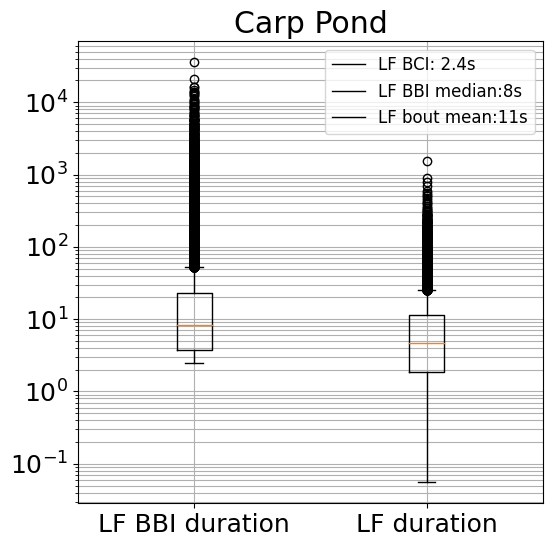

In [21]:
labels = [f'LF BCI: {round(lf_bci_carp/1000, 1)}s',
        f'LF BBI median:{round(np.median(ipis_s_lf_carp))}s',
        f'LF bout mean:{round(bout_metrics_LF_carp["bout_duration_in_secs"].mean())}s']

plt.figure(figsize=(6, 6))
plt.rcParams.update({'font.size':18})
plt.title(f'{SITE_NAMES[site_key]}')
plt.boxplot([ipis_s_lf_carp, bout_metrics_LF_carp['bout_duration_in_secs']])
plt.xticks([1, 2], ['LF BBI duration', 'LF duration'])
plt.yscale('log')
plt.legend(labels, fontsize=12, loc=1)
plt.grid(which='both')

plt.show()

In [22]:
site_key = 'Telephone'
data_params = dict()
data_params['site_tag'] = site_key
data_params['recording_start'] = '00:00'
data_params['recording_end'] = '16:00'
data_params['cur_dc_tag'] = '30of30'
data_params['cycle_length'] = int(data_params['cur_dc_tag'].split('of')[-1])
data_params['time_on'] = int(data_params['cur_dc_tag'].split('of')[0])
data_params['time_on_in_secs'] = 60*data_params['time_on']

pipeline_params = dict()
pipeline_params['assemble_location_summary'] = True
pipeline_params["read_csv"] = False
pipeline_params['use_threshold_to_group'] = False
pipeline_params['use_kmeans_to_group'] = True
freq_key = ''

data_params['type_tag'] = freq_key
file_paths = get_file_paths(data_params)

location_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["bd2_TYPE_SITE_YEAR"]}.csv', low_memory=False, index_col=0)
dc_applied_df = ss.simulate_dutycycle_on_detections(location_df.copy(), data_params)
bout_params = bt.get_bout_params_from_location(dc_applied_df, data_params)
tagged_dets = bt.classify_bouts_in_bd2_predictions_for_freqgroups(dc_applied_df, bout_params)
bout_metrics = bt.construct_bout_metrics_from_location_df_for_freqgroups(tagged_dets)

bout_metrics_LF_tel = bout_metrics[bout_metrics['freq_group']=='LF'].copy()
bout_metrics_HF_tel = bout_metrics[bout_metrics['freq_group']=='HF'].copy()

ipis_s_lf_tel = get_between_bout_intervals_in_secs(bout_metrics_LF_tel)
ipis_s_hf_tel = get_between_bout_intervals_in_secs(bout_metrics_HF_tel)
lf_bci_tel = bout_params['LF_bci']
hf_bci_tel = bout_params['HF_bci']

In [59]:
18000/60

300.0

In [60]:
bout_metrics_HF_tel[(bout_metrics_HF_tel['between_bout_intervals']<=pd.Timedelta(hours=12))&(bout_metrics_HF_tel['between_bout_intervals']>=pd.Timedelta(hours=2))]

,between_bout_intervals,start_time_of_bout,end_time_of_bout,start_time_wrt_ref,end_time_wrt_ref,start_time,end_time,low_freq,high_freq,freq_group,cycle_ref_time_start,cycle_ref_time_end,number_of_dets,bout_duration,bout_duration_in_secs,ref_time
16707,0 days 02:23:37.384500,2022-09-16 10:31:09.237500,2022-09-16 10:31:13.874800,69.2375,73.8748,69.2375,73.8748,36640.0,55178.0,HF,2022-09-16 10:30:00,2022-09-16 10:30:00,15,0 days 00:00:04.637300,4.6373,2022-09-16 10:31:09.237500
25182,0 days 02:16:45.023100,2022-09-29 07:55:54.337500,2022-09-29 07:55:55.982100,1554.3375,1555.9821,1554.3375,1555.9821,45234.0,59707.0,HF,2022-09-29 07:30:00,2022-09-29 07:30:00,6,0 days 00:00:01.644600,1.6446,2022-09-29 07:55:54.337500
25251,0 days 02:01:26.765600,2022-09-30 08:25:39.976500,2022-09-30 08:25:40.425700,1539.9765,1540.4257,1539.9765,1540.4257,46093.0,63691.0,HF,2022-09-30 08:00:00,2022-09-30 08:00:00,4,0 days 00:00:00.449200,0.4492,2022-09-30 08:25:39.976500
25414,0 days 02:34:31.313300,2022-10-01 08:45:47.051500,2022-10-01 08:45:48.674100,947.0515,948.6741,947.0515,948.6741,45234.0,61864.0,HF,2022-10-01 08:30:00,2022-10-01 08:30:00,8,0 days 00:00:01.622600,1.6226,2022-10-01 08:45:47.051500
25464,0 days 02:52:31.666900,2022-10-02 11:36:05.477500,2022-10-02 11:36:06.161000,365.4775,366.1610,365.4775,366.1610,45234.0,53682.0,HF,2022-10-02 11:30:00,2022-10-02 11:30:00,2,0 days 00:00:00.683500,0.6835,2022-10-02 11:36:05.477500
25465,0 days 02:03:38.775500,2022-10-02 13:39:44.936500,2022-10-02 13:39:45.188300,584.9365,585.1883,584.9365,585.1883,38359.0,52912.0,HF,2022-10-02 13:30:00,2022-10-02 13:30:00,4,0 days 00:00:00.251800,0.2518,2022-10-02 13:39:44.936500
25496,0 days 02:03:12.104300,2022-10-03 13:25:36.865500,2022-10-03 13:25:37.897200,1536.8655,1537.8972,1536.8655,1537.8972,46953.0,64126.0,HF,2022-10-03 13:00:00,2022-10-03 13:00:00,5,0 days 00:00:01.031700,1.0317,2022-10-03 13:25:36.865500
25544,0 days 02:40:34.948800,2022-10-04 08:31:31.960500,2022-10-04 08:31:32.927200,91.9605,92.9272,91.9605,92.9272,46093.0,56899.0,HF,2022-10-04 08:30:00,2022-10-04 08:30:00,3,0 days 00:00:00.966700,0.9667,2022-10-04 08:31:31.960500
26036,0 days 05:31:04.499900,2022-10-06 10:34:23.186500,2022-10-06 10:34:25.920800,263.1865,265.9208,263.1865,265.9208,40937.0,98424.0,HF,2022-10-06 10:30:00,2022-10-06 10:30:00,13,0 days 00:00:02.734300,2.7343,2022-10-06 10:34:23.186500
26300,0 days 02:53:58.727400,2022-10-07 09:41:02.089500,2022-10-07 09:41:02.287100,662.0895,662.2871,662.0895,662.2871,45234.0,54474.0,HF,2022-10-07 09:30:00,2022-10-07 09:30:00,2,0 days 00:00:00.197600,0.1976,2022-10-07 09:41:02.089500


In [58]:
ipis_s_hf_tel[ipis_s_hf_tel>3600]

array([ 4253.3613,  5895.7256,  3876.8433,  5411.25  ,  3933.9998,
        4353.246 ,  3854.7893,  3741.6667,  4315.355 ,  8617.385 ,
        3657.755 ,  5010.4087,  4290.0737,  7180.463 ,  4406.868 ,
        4740.3877,  4109.534 ,  5547.2217,  4752.412 ,  4001.206 ,
        4123.471 ,  3706.5833,  4933.228 ,  8205.023 ,  4527.331 ,
        7286.7656,  9271.3125,  5305.619 ,  4124.15  ,  5248.8594,
       10351.667 ,  7418.7754,  4595.401 ,  4782.2246,  6294.242 ,
        5174.063 ,  7392.1045,  9634.948 , 19864.5   , 10438.728 ,
       17392.916 ,  5628.9395, 14360.15  ,  5673.5137,  7965.698 ,
       10183.779 ,  3676.8774,  4605.9136,  3906.796 ,  4913.6553,
        7032.6274,  4492.0957, 11101.381 ,  7860.3843, 14136.922 ,
        4667.7837,  6336.9966], dtype=float32)

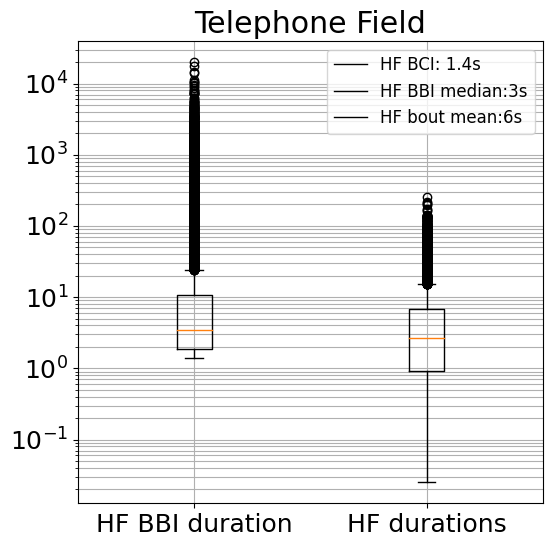

In [23]:
labels = [f'HF BCI: {round(hf_bci_tel/1000, 1)}s',
        f'HF BBI median:{round(np.median(ipis_s_hf_tel))}s',
        f'HF bout mean:{round(bout_metrics_HF_tel["bout_duration_in_secs"].mean())}s']

plt.figure(figsize=(6, 6))
plt.rcParams.update({'font.size':18})
plt.title(f'{SITE_NAMES[site_key]}')
plt.boxplot([ipis_s_hf_tel, bout_metrics_HF_tel['bout_duration_in_secs']])
plt.xticks([1, 2], ['HF BBI duration', 'HF durations'])
plt.yscale('log')
plt.legend(labels, fontsize=12, loc=1)
plt.grid(which='both')

plt.show()

In [ ]:
labels = [f'Carp Pond LF BCI: {round(lf_bci_carp/1000, 1)}s',
        f'Carp Pond LF BBI median:{round(np.median(ipis_s_lf_carp))}s',
        f'Carp Pond LF bout mean:{round(bout_metrics_LF_carp["bout_duration_in_secs"].mean())}s',
        f'Telephone Field HF BCI: {round(hf_bci_tel/1000, 1)}s',
        f'Telephone Field HF BBI median:{round(np.median(ipis_s_hf_tel))}s',
        f'Telephone Field HF bout mean:{round(bout_metrics_HF_tel["bout_duration_in_secs"].mean())}s']

plt.figure(figsize=(12, 6))
plt.rcParams.update({'font.size':18})
plt.title(f'{SITE_NAMES[site_key]}')
plt.boxplot([ipis_s_lf_carp, bout_metrics_LF_carp['bout_duration_in_secs'], ipis_s_hf_tel, bout_metrics_HF_tel['bout_duration_in_secs']])
plt.xticks([1, 2, 3, 4], ['Carp LF BBI', 'Carp LF', 'Telephone HF BBI', 'Telephone HF'])
plt.yscale('log')
plt.legend(labels, fontsize=12, loc=1)
plt.grid(which='both')

plt.show()

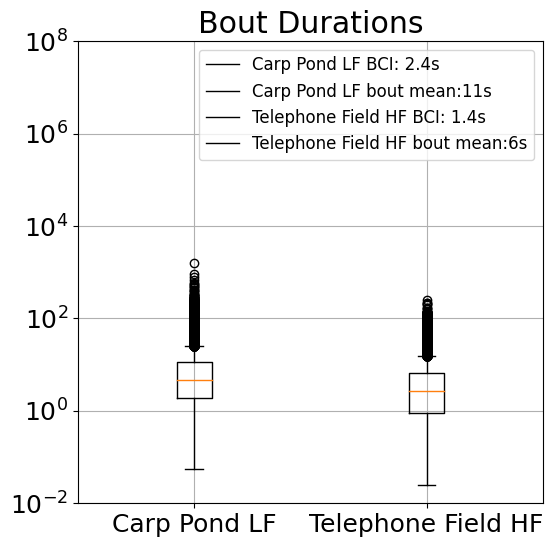

In [43]:
labels = [f'Carp Pond LF BCI: {round(lf_bci_carp/1000, 1)}s',
        f'Carp Pond LF bout mean:{round(bout_metrics_LF_carp["bout_duration_in_secs"].mean())}s',
        f'Telephone Field HF BCI: {round(hf_bci_tel/1000, 1)}s',
        f'Telephone Field HF bout mean:{round(bout_metrics_HF_tel["bout_duration_in_secs"].mean())}s']

plt.figure(figsize=(6, 6))
plt.rcParams.update({'font.size':18})
plt.title(f'Bout Durations')
plt.boxplot([bout_metrics_LF_carp['bout_duration_in_secs'], bout_metrics_HF_tel['bout_duration_in_secs']])
plt.xticks([1, 2], ['Carp Pond LF', 'Telephone Field HF'])
plt.yscale('log')
plt.ylim(1e-2, 1e8)
plt.legend(labels, fontsize=12, loc=1)
plt.grid(which='both')

plt.show()

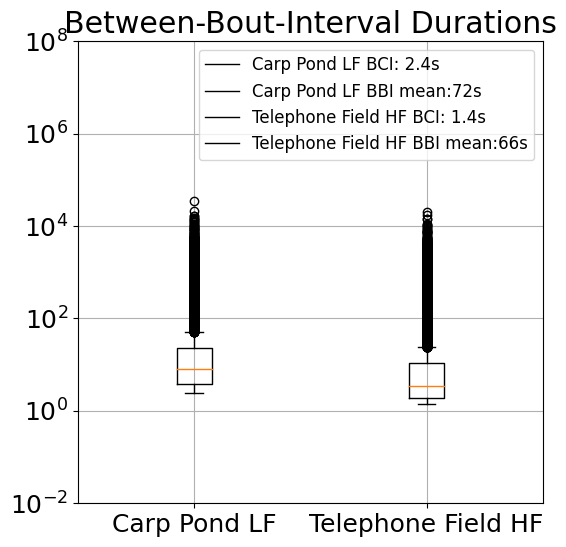

In [49]:
labels = [f'Carp Pond LF BCI: {round(lf_bci_carp/1000, 1)}s',
        f'Carp Pond LF BBI mean:{round(np.mean(ipis_s_lf_carp))}s',
        f'Telephone Field HF BCI: {round(hf_bci_tel/1000, 1)}s',
        f'Telephone Field HF BBI mean:{round(np.mean(ipis_s_hf_tel))}s']

plt.figure(figsize=(6, 6))
plt.rcParams.update({'font.size':18})
plt.title(f'Between-Bout-Interval Durations')
plt.boxplot([ipis_s_lf_carp, ipis_s_hf_tel])
plt.xticks([1, 2], ['Carp Pond LF', 'Telephone Field HF'])
plt.yscale('log')
plt.ylim(1e-2, 1e8)
plt.legend(labels, fontsize=12, loc=1)
plt.grid(which='both')

plt.show()